# Análise da comparação entre as palavras das sentenças do CohQuAD Co pt-br 

Realiza a análise da comparação entre  as palavras das sentenças dos documentos originais e perturbados dos dados  utilizando o arquivo:
- `comparacao_palavra_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.1 MB/s 
     |████████████████████████████████| 181 kB 55.8 MB/s 
     |████████████████████████████████| 162 kB 57.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 158 kB 50.9 MB/s 
     |████████████████████████████████| 157 kB 67.9 MB/s 
     |████████████████████████████████| 157 kB 70.2 MB/s 
     |████████████████████████████████| 157 kB 58.8 MB/s 
     |████████████████████████████████| 157 kB 46.5 MB/s 
     |████████████████████████████████| 157 kB 47.9 MB/s 
     |████████████████████████████████| 157 kB 56.7 MB/s 
     |████████████████████████████████| 157 kB 56.7 MB/s 
     |████████████████████████████████| 156 kB 56.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=69f411f6a91bd6faa45fae5b751b0d2524c7a128e51a0c645dd567a0c77c

# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 20

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 20

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    
    #pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_CO_PTBR"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import de bibliotecas
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação das palavras



## 3.1 Carregamento dos arquivos de dados originais e perturbados

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import de bibliotecas
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_CO_PTBR


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
# Import de bibliotecas
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
14,15,['O que é uma pilha e como empilhar e desempil...,O que é uma pilha e como empilhar e desempilha...
15,16,['O que é uma fila e como enfileirar e desenfi...,O que é uma fila e como enfileirar e desenfile...
0,1,['Como enfileirar elementos em uma fila?'],Como enfileirar elementos em uma fila?
1,2,['Como desenfileirar elementos em uma fila?'],Como desenfileirar elementos em uma fila?
13,14,['O que é uma pilha e como empilhar um element...,O que é uma pilha e como empilhar um elemento ...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
15,16,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
1,2,"[[['Como', 'desenfileirar', 'elementos', 'em',..."
17,18,"[[['Como', 'são', 'implementadas', 'as', 'oper..."
18,19,"[[['Em', 'uma', 'pilha', 'a', 'operação', 'de'..."
19,20,"[[['Em', 'uma', 'fila', 'a', 'operação', 'de',..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?
4,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma p...
5,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


AlgUns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
2,3_pert_0,['Como colocar elementos em uma pilha ?'],Como colocar elementos em uma pilha ?,"[['Como [MASK] elementos em uma pilha ?', 'emp..."
15,16_pert_0,['O que é uma fila e como organizar e desenfil...,O que é uma fila e como organizar e desenfilei...,[['O que é uma fila e como [MASK] e desenfilei...
19,20_pert_0,['Em uma fila a operação de enfileirar ocorre ...,Em uma fila a operação de enfileirar ocorre em...,[['Em uma fila a operação de enfileirar [MASK]...
9,10_pert_0,['O que é uma fila e como identificar seu elem...,O que é uma fila e como identificar seu elemen...,[['O que é uma fila e como [MASK] seu elemento...
0,1_pert_0,['Como colocar elementos em uma fila ?'],Como colocar elementos em uma fila ?,"[['Como [MASK] elementos em uma fila ?', 'enfi..."


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
11,12_pert_0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
7,8_pert_0,"[[['Como', 'desempilhar', 'dados', 'em', 'uma'..."
15,16_pert_0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
2,3_pert_0,"[[['Como', 'colocar', 'elementos', 'em', 'uma'..."
4,5_pert_0,"[[['Como', 'identificar', 'elementos', 'em', '..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, enfilei..."
2_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, desenfi..."
3_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, empilh..."
4_pert_0,[Como empilhar e organizar elementos em uma pi...,Como empilhar e organizar elementos em uma pil...,[[Como empilhar e [MASK] elementos em uma pilh...
5_pert_0,[Como identificar elementos em uma estrutura d...,Como identificar elementos em uma estrutura de...,[[Como [MASK] elementos em uma estrutura de da...


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."
2_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."
3_pert_0,"[[[Como, colocar, elementos, em, uma, pilha, ?..."
4_pert_0,"[[[Como, empilhar, e, organizar, elementos, em..."
5_pert_0,"[[[Como, identificar, elementos, em, uma, estr..."


### 5.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
32,17,[Como são implementadas as operações de empilh...,Como são implementadas as operações de empilha...,1
39,20_pert_0,[Em uma fila a operação de enfileirar ocorre e...,Em uma fila a operação de enfileirar ocorre em...,0
30,16,[O que é uma fila e como enfileirar e desenfil...,O que é uma fila e como enfileirar e desenfile...,1
33,17_pert_0,[Como são implementadas as operações de empilh...,Como são implementadas as operações de empilha...,0
6,4,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma p...,1


In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

,id,pos_documento
10,11_pert_0,"[[[O, que, é, uma, fila, e, como, desenfileira..."
13,14_pert_0,"[[[O, que, é, uma, pilha, e, como, colocar, um..."
8,9,"[[[O, que, é, uma, pilha, e, como, empilhar, s..."
12,13,"[[[O, que, é, uma, fila, e, como, enfileirar, ..."
1,2_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."


#### Criar dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?,1
1_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,0
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?,1
2_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,0
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?,1


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


## 3.2 Carregamento do arquivo de dado comparação 

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_COMPACTADO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_CO_PTBR


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_palavra = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_palavra)))

INFO:root:TERMINADO ORIGINAIS: 2240.


In [ ]:
lista_comparacao_palavra.sample(5)

,id,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
384,6_pert_0,11,0,3,organizar,VERB,4,elementos,NOUN,0.653219,33.052074,1572.0449,0.653219,33.052074,1572.0449
2209,20_pert_0,39,0,3,a,DET,9,qual,DET,0.675571,31.750504,1570.6509,0.675571,31.750504,1570.6509
1313,15,28,0,1,que,PRON,3,uma,DET,0.569039,36.380280,1810.3934,0.569039,36.380280,1810.3934
1007,12_pert_0,23,0,3,uma,DET,11,?,PUNCT,0.627126,32.866222,1636.4441,0.627126,32.866222,1636.4441
2122,20,38,0,1,uma,DET,5,de,SCONJ,0.650360,32.111942,1611.2188,0.650360,32.111942,1611.2188


### 3.5.5 Criando dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id", "index_sentenca", "index_wi", "index_wj"])
lista_comparacao_palavra_indexado.head()

index_documento    wi  pos_i          wj  \
id index_sentenca index_wi index_wj                                             
1  0              0        1                       0  Como  SCONJ  enfileirar   
                           2                       0  Como  SCONJ   elementos   
                           3                       0  Como  SCONJ          em   
                           4                       0  Como  SCONJ         uma   
                           5                       0  Como  SCONJ        fila   

                                    pos_j  cos_mean   euc_mean   man_mean  \
id index_sentenca index_wi index_wj                                         
1  0              0        1         VERB  0.759586  25.941952  1294.4813   
                           2         NOUN  0.607320  37.124222  1770.7854   
                           3          ADP  0.658418  33.079350  1641.0864   
                           4          DET  0.700411  29.079645  1441.1697   
                           5         NOUN  0.630520  31.865469  1558.0065   

                                      cos_max    euc_max    man_max  
id index_sentenca index_wi index_wj                                  
1  0              0        1         0.673417  31.297092  1554.1917  
                           2         0.607320  37.124222  1770.7854  
                           3         0.658418  33.079350  1641.0864  
                           4         0.700411  29.079645  1441.1697  
                           5         0.578515  35.350060  1716.5850

## 3.3 Estatísticas

### Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_palavra[["cos_mean", "euc_mean", "man_mean", "cos_max", "euc_max", "man_max" ]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,0.627971,33.495596,1596.039103,0.605840,34.979704,1668.857586
std,0.125197,5.332136,209.261450,0.126985,5.419374,221.221409
min,0.055016,6.765657,166.194550,0.055016,6.765657,166.194550
25%,0.582660,29.917229,1459.655750,0.552873,31.803438,1544.672000
50%,0.644838,33.167751,1614.486350,0.617488,34.936523,1681.595550
75%,0.697734,36.748666,1737.844725,0.675571,38.515692,1822.330850
max,0.967897,51.497929,2187.814500,0.967897,54.258480,2287.402300


### Estatísticas das maiores discrepâncias por documento

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

discrepancias  = lista_comparacao_palavra.groupby("id").agg({"cos_mean":[coluna_discrepancia_cos], 
                                                             "euc_mean":[coluna_discrepancia_euc], 
                                                             "man_mean":[coluna_discrepancia_man],
                                                             "cos_max":[coluna_discrepancia_cos], 
                                                             "euc_max":[coluna_discrepancia_euc], 
                                                             "man_max":[coluna_discrepancia_man],
                                                             })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
,min,max,max,min,max,max
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.449600,43.211695,1948.037342,0.432724,44.050004,2015.765920
std,0.162368,4.711286,141.625308,0.158440,5.102246,160.505282
min,0.055016,34.545361,1687.682600,0.055016,34.545361,1694.120400
25%,0.439142,38.831437,1844.467700,0.434732,40.530242,1923.208100
50%,0.505835,43.155760,1949.227900,0.472671,43.715412,2039.860650
75%,0.576382,47.309640,2083.970250,0.541693,47.548368,2130.227475
max,0.607332,51.497929,2187.814500,0.607332,54.258480,2287.402300


### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])

1 uma 40
2 ? 40
3 e 28
4 em 24
5 pilha 24
6 elementos 22
7 Como 20
8 fila 16
9 O 16
10 que 16
11 é 16
12 como 16
13 de 14
14 empilhar 12
15 desempilhar 11
16 elemento 10
17 um 8
18 nela 8
19 enfileirar 7
20 desenfileirar 7


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### COS

In [ ]:
medida = "cos"

#### MEAN

In [ ]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,0.682205,0.070790,0.528791,0.626701,0.675336,0.735125,0.860071
ADV,140.000000,0.641671,0.118159,0.110271,0.575340,0.658059,0.720740,0.828181
AUX,192.000000,0.605792,0.120620,0.064609,0.554692,0.627510,0.675758,0.834019
CCONJ,166.000000,0.526927,0.228467,0.102830,0.270784,0.599600,0.693161,0.967897
DET,349.000000,0.658132,0.097259,0.134931,0.627936,0.658949,0.709318,0.848679
NOUN,434.000000,0.626142,0.085639,0.134436,0.584635,0.627650,0.678002,0.886582
PRON,346.000000,0.601677,0.132708,0.055016,0.514669,0.593586,0.696153,0.822129
SCONJ,148.000000,0.645610,0.108088,0.102925,0.605658,0.645243,0.713853,0.811196
VERB,277.000000,0.648450,0.112222,0.107877,0.605025,0.662170,0.705927,0.906370


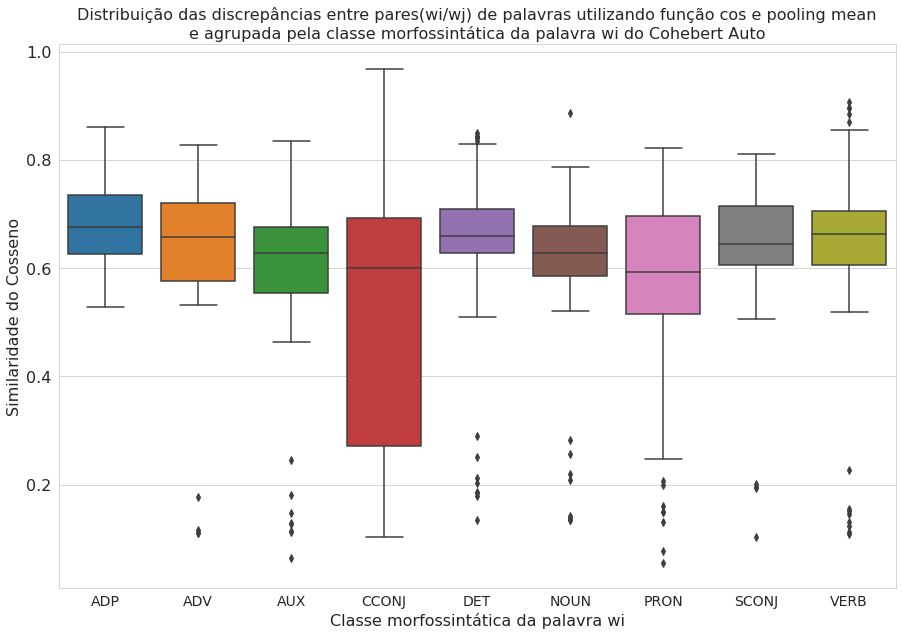

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,173.000000,0.670852,0.100016,0.102830,0.631838,0.673363,0.720448,0.842426
ADV,122.000000,0.645808,0.117887,0.133869,0.615613,0.663977,0.713371,0.894790
AUX,36.000000,0.737840,0.040138,0.666537,0.712070,0.734905,0.764766,0.814929
CCONJ,148.000000,0.488107,0.249954,0.055016,0.200387,0.596930,0.673416,0.967897
DET,363.000000,0.651108,0.108047,0.127540,0.600519,0.657619,0.713597,0.896524
NOUN,647.000000,0.612921,0.103209,0.128283,0.553260,0.626233,0.683086,0.886582
PRON,105.000000,0.611898,0.091754,0.425773,0.547007,0.620607,0.675571,0.780183
PUNCT,394.000000,0.643249,0.101741,0.127486,0.591703,0.628672,0.686598,0.845937
SCONJ,41.000000,0.673271,0.061958,0.558610,0.641389,0.659659,0.703301,0.800602


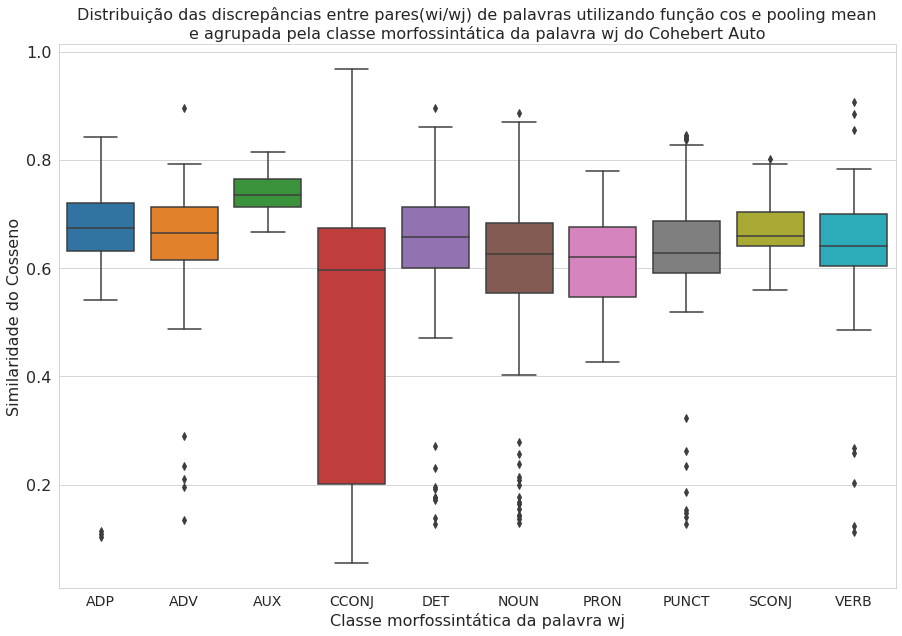

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

#### MAX

In [ ]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,0.675220,0.072998,0.506135,0.616767,0.669536,0.722122,0.860071
ADV,140.000000,0.611783,0.121239,0.110271,0.552685,0.607900,0.680852,0.828181
AUX,192.000000,0.591962,0.125070,0.064609,0.534408,0.615446,0.674528,0.834019
CCONJ,166.000000,0.513684,0.228192,0.078584,0.264719,0.572947,0.668057,0.967897
DET,349.000000,0.644795,0.101621,0.134931,0.610022,0.652714,0.690081,0.848679
NOUN,434.000000,0.600923,0.086813,0.119198,0.554579,0.601129,0.651046,0.886582
PRON,346.000000,0.592947,0.137240,0.055016,0.499159,0.584534,0.696153,0.822129
SCONJ,148.000000,0.626869,0.106565,0.102925,0.587614,0.626557,0.673516,0.811196
VERB,277.000000,0.584090,0.109506,0.087220,0.542306,0.588454,0.643064,0.882059


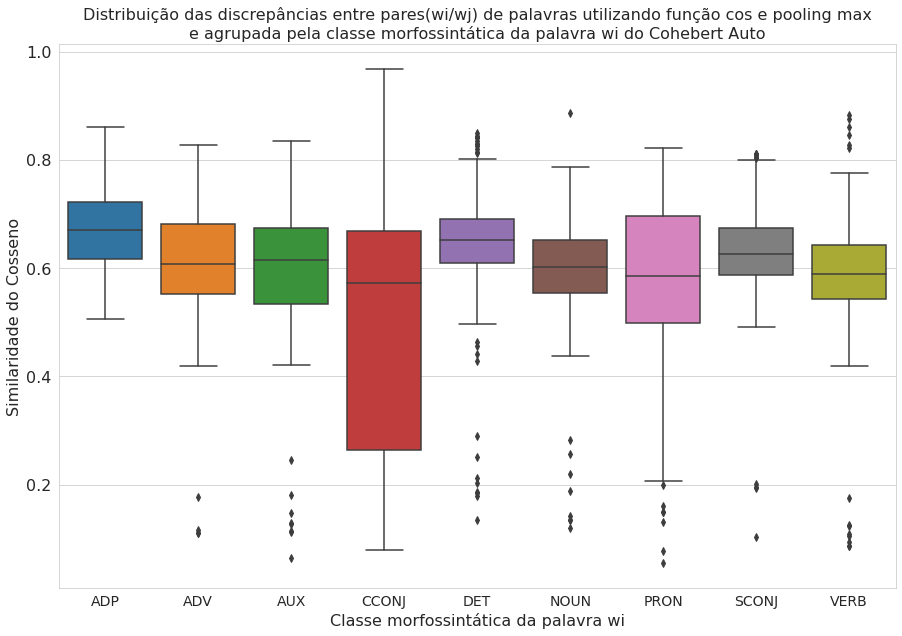

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,173.000000,0.646844,0.101644,0.102830,0.601300,0.646049,0.695884,0.842426
ADV,122.000000,0.618927,0.133055,0.086097,0.534412,0.648151,0.700233,0.882059
AUX,36.000000,0.737840,0.040138,0.666537,0.712070,0.734905,0.764766,0.814929
CCONJ,148.000000,0.481245,0.249611,0.055016,0.195239,0.589760,0.669859,0.967897
DET,363.000000,0.634336,0.109694,0.099013,0.587362,0.641313,0.693624,0.875210
NOUN,647.000000,0.587327,0.102957,0.128283,0.532904,0.586257,0.659946,0.886582
PRON,105.000000,0.600474,0.091243,0.425773,0.539510,0.600080,0.652685,0.780183
PUNCT,394.000000,0.630537,0.106943,0.127486,0.577672,0.616052,0.674176,0.845937
SCONJ,41.000000,0.666270,0.070793,0.519028,0.638403,0.657939,0.703301,0.800602


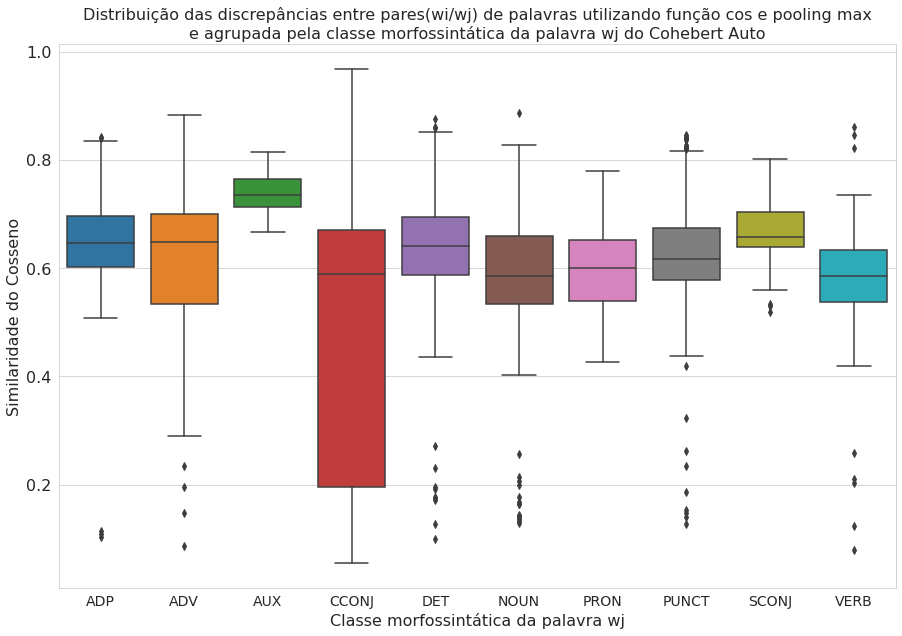

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

### EUC

In [ ]:
medida = "euc"

#### MEAN

In [ ]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,32.500634,5.151138,21.245766,28.427049,32.409313,35.181655,49.856640
ADV,140.000000,32.680179,4.934122,22.571783,28.987073,32.409584,36.365792,43.645554
AUX,192.000000,34.214050,4.450426,21.844135,31.404600,33.556456,37.231068,47.151665
CCONJ,166.000000,34.922285,7.192599,6.765657,29.607134,34.796486,40.608159,50.941257
DET,349.000000,31.963637,4.567704,20.988617,29.288496,31.919479,33.706074,45.724308
NOUN,434.000000,34.721208,4.711845,17.779648,31.867648,34.438446,37.237804,51.497929
PRON,346.000000,34.410424,5.797104,22.927687,29.852200,34.858559,38.329584,50.019108
SCONJ,148.000000,32.733730,5.378745,23.407797,28.866210,32.965765,35.323807,48.332291
VERB,277.000000,32.504264,5.191184,15.100810,29.268860,32.334633,35.891922,50.615463


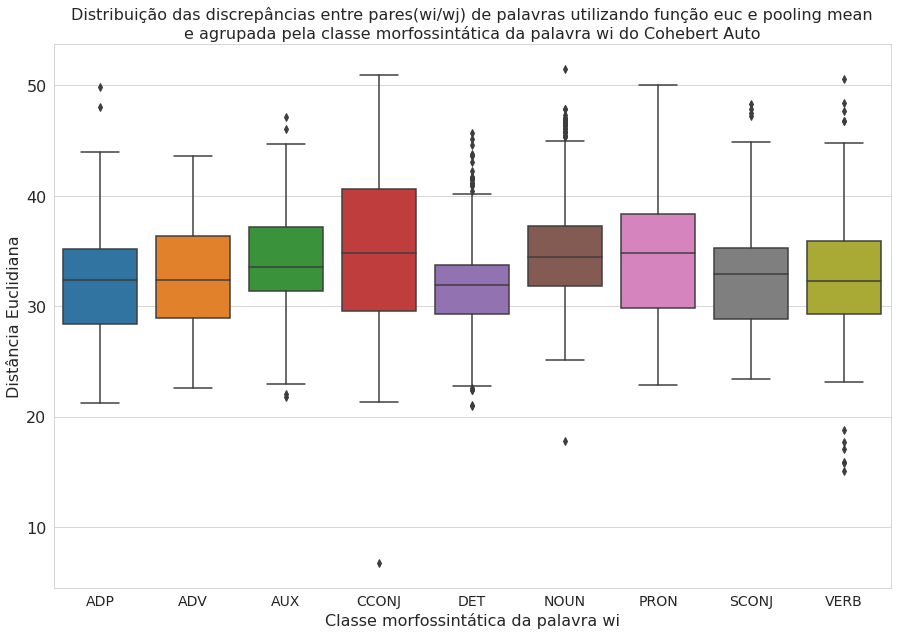

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,173.000000,32.121295,4.112345,22.434294,29.292616,32.620518,34.591202,46.196293
ADV,122.000000,31.872161,4.264483,15.822482,29.237407,32.285379,34.015424,43.236553
AUX,36.000000,28.431428,2.176516,23.237152,27.362672,28.803879,29.660672,31.870003
CCONJ,148.000000,35.099847,6.760261,6.765657,30.614123,34.549530,41.271381,46.170212
DET,363.000000,31.856342,4.530637,15.895111,28.937135,32.019783,34.861847,43.425072
NOUN,647.000000,35.681190,5.613694,17.706589,31.532486,35.079510,39.347198,51.497929
PRON,105.000000,35.267669,4.601314,26.294678,32.157146,35.622219,38.423512,44.367363
PUNCT,394.000000,32.577495,4.971130,21.304848,29.467781,32.954748,35.584730,47.861458
SCONJ,41.000000,31.412085,3.489041,23.969160,29.704063,31.995245,34.025158,37.917637


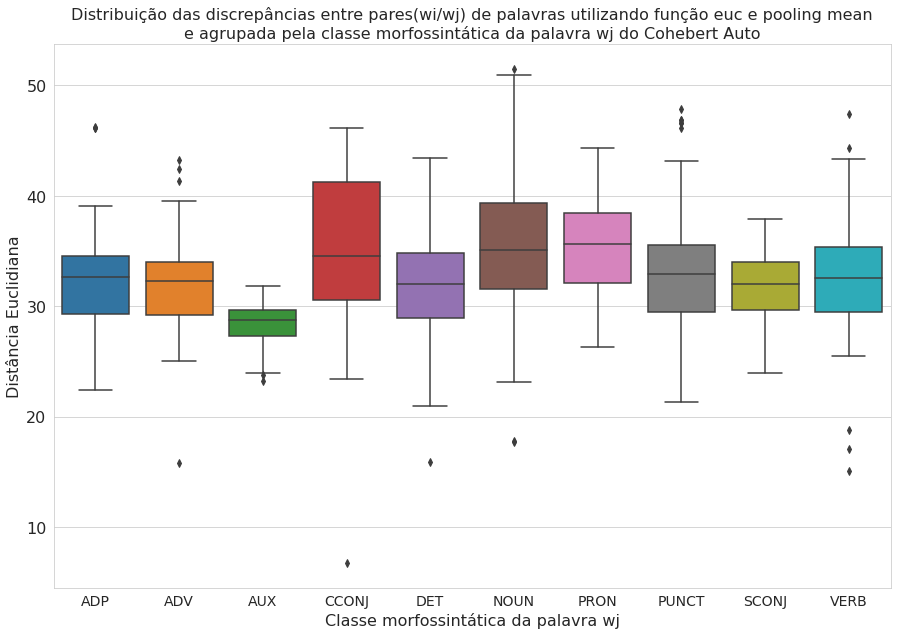

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAX

In [ ]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,32.936454,5.090108,21.245766,29.414333,32.699196,35.339264,49.856640
ADV,140.000000,34.664414,5.271542,22.571783,31.289167,35.304970,38.677629,44.043137
AUX,192.000000,35.166018,4.839578,21.844135,31.715133,34.357998,38.673061,47.151665
CCONJ,166.000000,36.007725,7.384835,6.765657,31.312799,36.253143,41.819088,50.941257
DET,349.000000,32.863103,4.732540,20.988617,30.531174,32.472668,35.241737,45.724308
NOUN,434.000000,36.369940,4.361904,17.779648,33.731700,36.092300,38.306714,53.486431
PRON,346.000000,35.049036,6.146554,22.927687,30.019615,35.750975,39.876945,50.019108
SCONJ,148.000000,33.946843,5.155030,23.407797,31.575014,33.991018,36.278264,48.332291
VERB,277.000000,36.734414,4.743507,20.834465,34.161160,36.417675,39.178631,54.258480


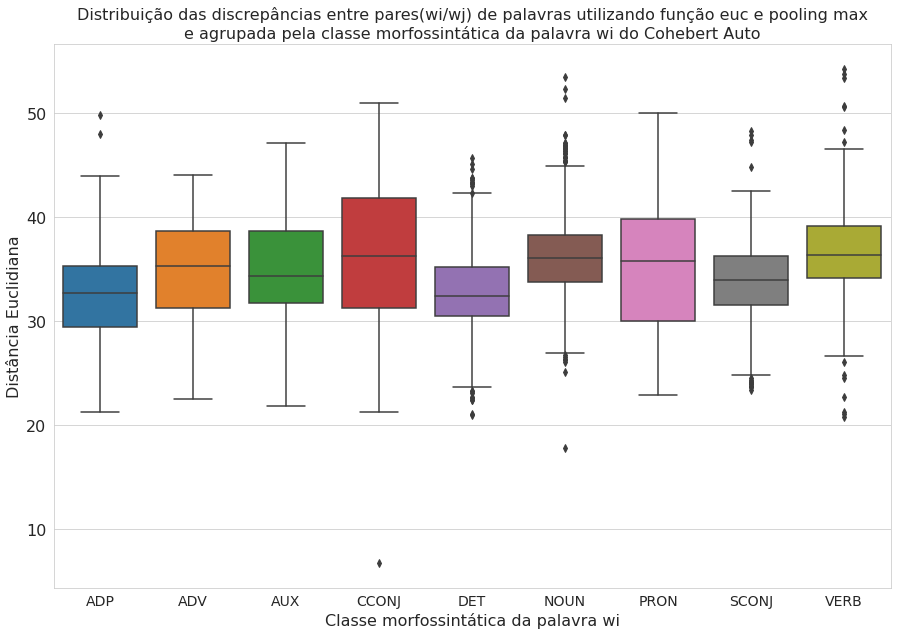

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,173.000000,33.558668,4.208130,22.434294,31.730413,33.862785,36.082832,46.196293
ADV,122.000000,33.993887,5.506936,20.834465,31.003243,32.841705,38.185873,48.211346
AUX,36.000000,28.431428,2.176516,23.237152,27.362672,28.803879,29.660672,31.870003
CCONJ,148.000000,35.715373,6.896688,6.765657,30.915113,35.872030,42.067911,47.232845
DET,363.000000,32.988505,4.652138,20.988617,30.283493,32.878639,35.914474,47.579941
NOUN,647.000000,37.345568,5.299014,17.779648,33.655981,37.595627,40.538574,54.258480
PRON,105.000000,35.960740,4.601433,26.294678,33.676075,36.745762,39.190804,44.367363
PUNCT,394.000000,33.408057,5.223683,21.304848,31.358776,34.044083,36.571837,47.861458
SCONJ,41.000000,31.904544,3.994920,23.969160,29.704063,32.111942,34.500435,39.178631


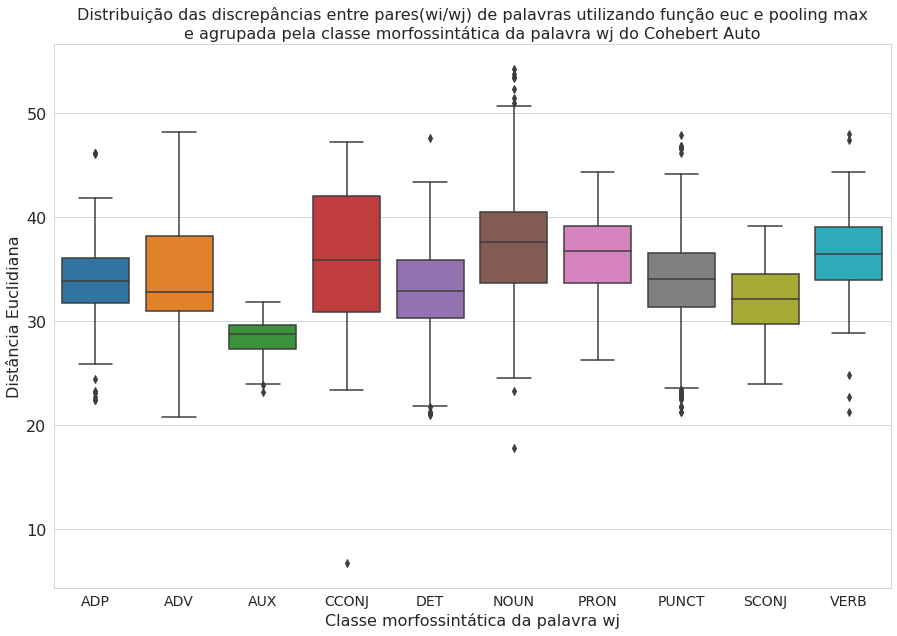

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

### MAN

In [ ]:
medida = "man"

#### MEAN

In [ ]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,1546.363943,198.426233,1040.423300,1405.349600,1581.776100,1674.097800,1954.044900
ADV,140.000000,1598.994829,213.488606,1105.814000,1447.460700,1596.465250,1748.661875,1973.384600
AUX,192.000000,1638.818100,164.219828,1089.487000,1542.775450,1636.675450,1760.660425,2055.090800
CCONJ,166.000000,1577.503534,235.474332,166.194550,1455.020525,1612.248750,1718.168575,1945.004200
DET,349.000000,1539.484906,180.949228,1045.124300,1415.438700,1571.972900,1655.183300,1963.912800
NOUN,434.000000,1622.277227,161.767647,855.080500,1521.711300,1646.021400,1740.922275,1955.239000
PRON,346.000000,1673.606360,260.810836,1115.237000,1465.071550,1724.728100,1861.724325,2187.814500
SCONJ,148.000000,1584.671895,208.363710,1154.737800,1419.384175,1643.112950,1715.210850,1983.691200
VERB,277.000000,1549.044915,212.578025,729.162960,1427.555000,1553.009200,1713.015100,2009.080800


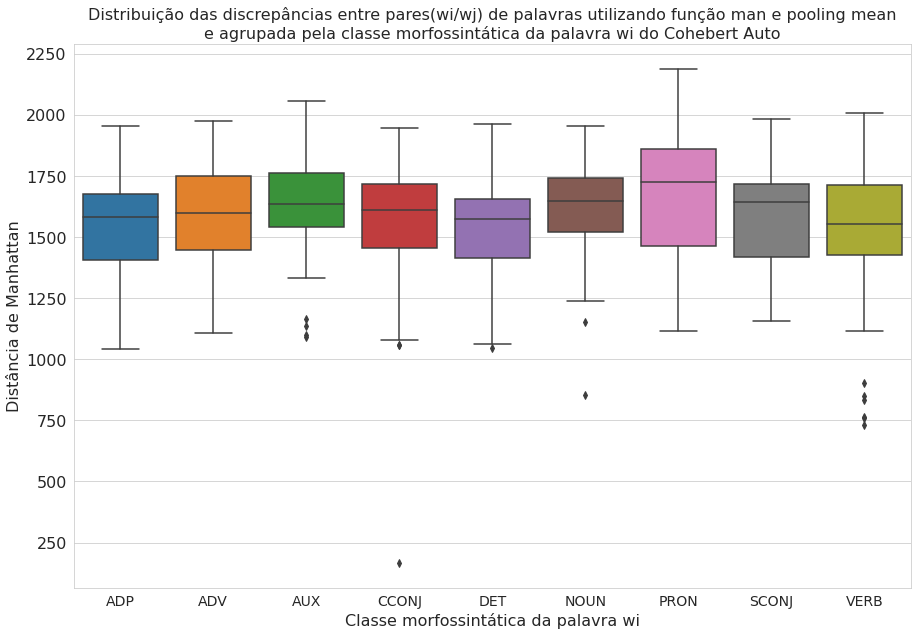

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,173.000000,1565.040240,174.444614,1128.555900,1432.595600,1591.627700,1696.521400,1865.410000
ADV,122.000000,1548.090724,186.273672,763.847660,1418.096275,1595.445350,1667.125825,1870.535400
AUX,36.000000,1397.775572,103.144222,1146.976600,1352.413075,1413.796650,1457.485050,1566.615000
CCONJ,148.000000,1579.242373,221.293668,166.194550,1498.563950,1630.405200,1714.040050,2023.566400
DET,363.000000,1555.460992,207.582659,759.759100,1425.947900,1584.542100,1694.522450,2029.683700
NOUN,647.000000,1646.222261,207.414452,848.396240,1497.834450,1650.677600,1801.692250,2187.814500
PRON,105.000000,1731.403630,217.069980,1307.545500,1582.390600,1739.796400,1894.308300,2128.008300
PUNCT,394.000000,1588.592117,209.288323,1059.640300,1476.405250,1636.065500,1735.821325,1923.505700
SCONJ,41.000000,1531.446995,157.536045,1184.532600,1436.457400,1537.689200,1646.415300,1793.958600


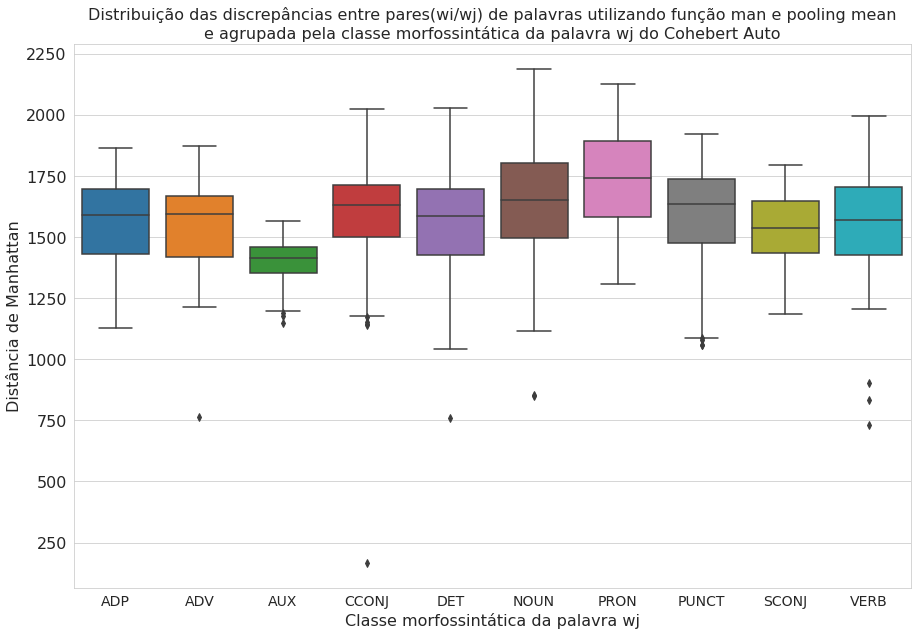

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

#### MAX

In [ ]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,1566.404277,198.446859,1040.423300,1434.356000,1589.251500,1703.598050,1970.579700
ADV,140.000000,1697.507166,239.233747,1105.814000,1555.591075,1723.860700,1889.137650,2209.429400
AUX,192.000000,1688.056417,195.771146,1089.487000,1555.295625,1667.332850,1827.415175,2163.517300
CCONJ,166.000000,1640.254059,256.646730,166.194550,1536.390300,1679.813600,1815.248525,2073.417000
DET,349.000000,1582.858449,196.862035,1045.124300,1478.782000,1597.496700,1682.459000,2142.216000
NOUN,434.000000,1702.205966,160.771904,855.080500,1604.739950,1716.485100,1811.266775,2166.371000
PRON,346.000000,1706.495245,282.351140,1115.237000,1478.350875,1756.903600,1928.311950,2287.402300
SCONJ,148.000000,1641.447993,205.598481,1154.737800,1565.394950,1667.107300,1760.214425,2073.053000
VERB,277.000000,1751.481350,188.611698,980.431300,1644.763500,1768.131500,1881.326700,2215.640100


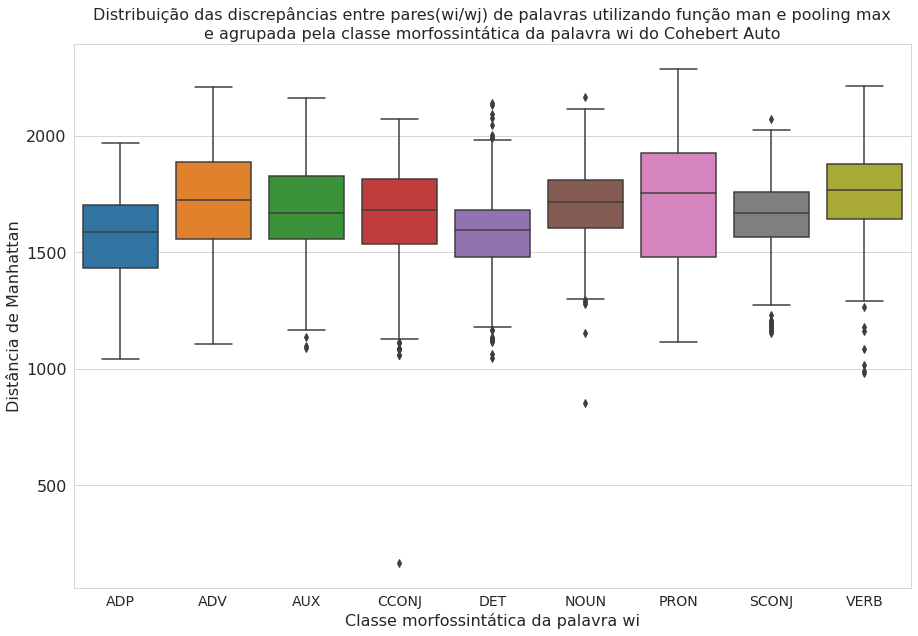

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,173.000000,1630.507613,180.487508,1128.555900,1534.682700,1661.159200,1741.866500,2026.557700
ADV,122.000000,1657.119933,250.306046,980.431300,1516.557800,1638.321150,1845.200325,2275.424800
AUX,36.000000,1397.775572,103.144222,1146.976600,1352.413075,1413.796650,1457.485050,1566.615000
CCONJ,148.000000,1613.875583,226.484730,166.194550,1532.186275,1655.110950,1740.761650,2023.566400
DET,363.000000,1610.688458,215.202241,990.462160,1492.661750,1628.519500,1742.067500,2154.671100
NOUN,647.000000,1728.606210,204.327233,855.080500,1579.326200,1741.021200,1873.787700,2287.402300
PRON,105.000000,1763.759388,218.460519,1307.545500,1632.028100,1789.544100,1920.762800,2128.008300
PUNCT,394.000000,1627.974795,229.823887,1059.640300,1545.118525,1670.193350,1787.152325,2215.640100
SCONJ,41.000000,1557.211615,187.482433,1184.532600,1436.457400,1557.487000,1676.937300,1924.080300


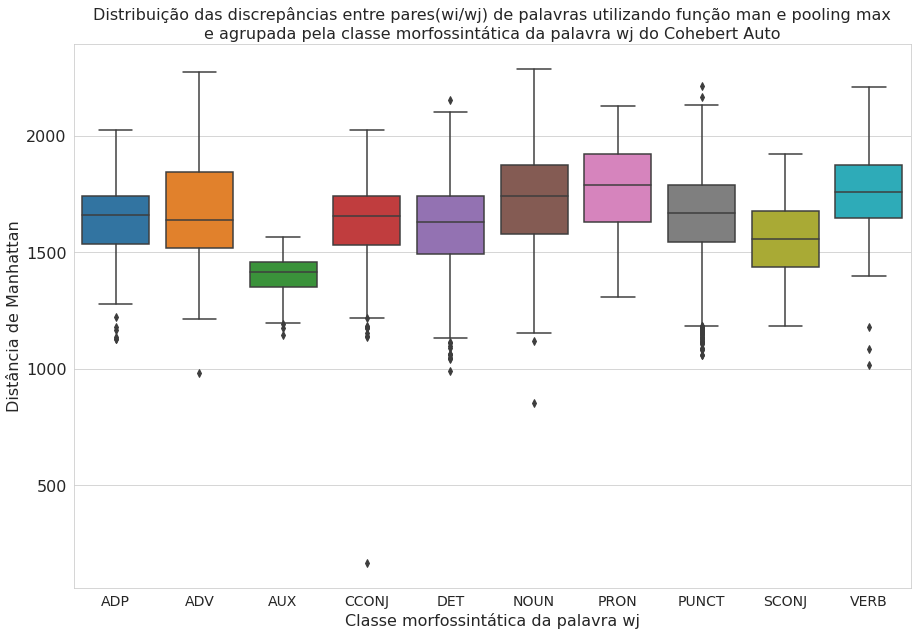

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias de determinados pares de palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_palavra.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_palavra))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao["pos_i"]+"/"+linha_comparacao["pos_j"]] += 1

Documentos:   0%|          | 0/2240 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

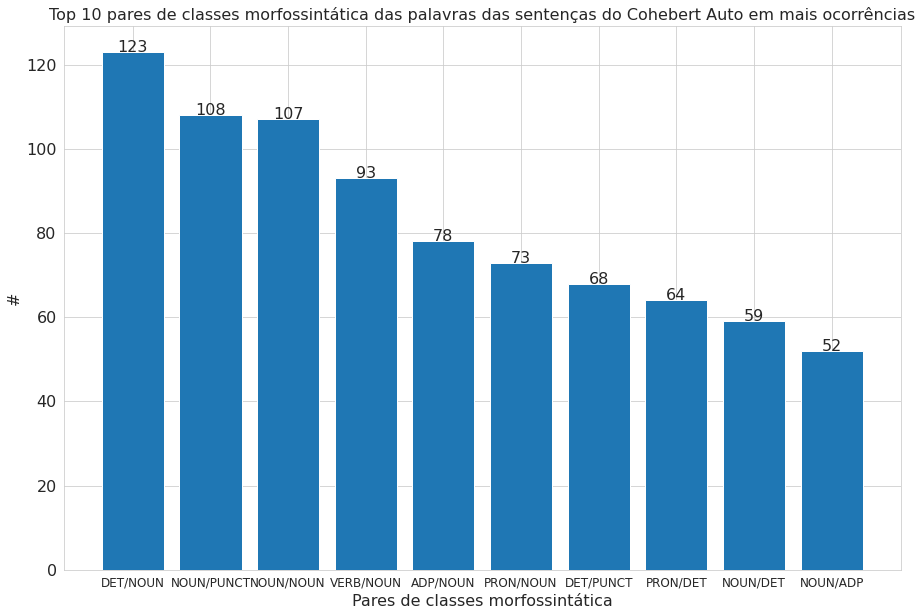

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### VERB-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 17


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.695044,29.762360,1422.208011,0.623768,35.593426,1694.955853
std,0.112588,7.228043,342.101634,0.115378,6.741187,318.320945
min,0.527439,15.100810,729.162960,0.490000,21.262541,1015.052700
25%,0.620434,25.524544,1240.604000,0.559292,33.778130,1611.708100
50%,0.639478,32.151291,1543.940000,0.585618,37.688511,1771.910200
75%,0.776540,35.893177,1684.711700,0.637962,40.000797,1903.361800
max,0.906370,38.824390,1872.722400,0.860713,43.094475,2020.639600


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/17 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1      empilhar    7
      2 implementadas    7
      3    enfileirar    2
      4       separar    1


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/17 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wj
      1   desempilhar    4
      2     organizar    4
      3        ocorre    3
      4      empilhar    2
      5 desenfileirar    2
      6    enfileirar    1
      7       separar    1


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.15610557794570923
Limite superior             : 1.0106983482837677
Limite inferior             : 0.3862760365009308


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 17 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 17 ( 0.0 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 17 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 10.368633270263672
Limite superior             : 51.44612693786621
Limite inferior             : 9.971593856811523


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 17 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 17 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 17 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 444.1077
Limite superior             : 2350.87325
Limite inferior             : 574.44245


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 17 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 17 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 17 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

### NOUN-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 107


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,0.664964,35.111765,1563.541605,0.633130,37.037370,1661.068188
std,0.043808,6.217116,158.576033,0.066997,6.195846,191.863527
min,0.544144,17.779648,855.080500,0.472500,17.779648,855.080500
25%,0.637731,30.701530,1442.609250,0.583259,32.927935,1537.713300
50%,0.664828,33.947063,1548.993500,0.637278,36.164013,1687.696400
75%,0.691801,36.894691,1692.520750,0.682434,40.367443,1781.305050
max,0.886582,51.497929,1881.839800,0.886582,53.486431,2050.921900


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/107 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wi
      1   elementos   28
      2       pilha   17
      3 desempilhar   14
      4   estrutura   12
      5        fila   12
      6       dados    9
      7   operações    8
      8    operação    5
      9        água    1
     10       carga    1


Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/107 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1       pilha   31
      2       dados   15
      3   elementos   12
      4    elemento   11
      5 extremidade    9
      6        fila    8
      7   estrutura    8
      8 desempilhar    4
      9    operação    4
     10    material    2
     11       carga    2
     12       carro    1


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05407056212425232
Limite superior             : 0.7729070335626602
Limite inferior             : 0.5566247850656509


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 107 ( 0.009345794392523364 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 107 ( 0.018691588785046728 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 107 ( 0.028037383177570093 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.8865816593170166 dados dados
         Como desempilhar dados em uma estrutura de dados pilha ? 0

 2 0.7875463962554932 pilha carga
         Em uma pilha a operação de carga ocorre em qual extremidade ? 0


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.5441442131996155 dados pilha
         Como desempilhar dados em uma estrutura de dados pilha ? 0


#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.193161964416504
Limite superior             : 46.18443441390991
Limite inferior             : 21.411786556243896


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 10


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 107 ( 0.009345794392523364 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  11 de 107 ( 0.102803738317757 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 51.497928619384766 dados pilha
         Como desempilhar dados em uma estrutura de dados pilha ? 0

 2 47.86405944824219 dados pilha
         Como desempilhar dados em uma estrutura de dados pilha ? 0

 3 47.29149627685547 desempilhar pilha
         Como desempilhar dados em uma estrutura de dados pilha ? 0

 4 47.091285705566406 dados pilha
         Como desempilhar elementos em uma estrutura de dados pilha? 1

 5 47.09049987792969 elementos pilha
         Como empilhar e organizar elementos em uma estrutura de dados pilha ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 17.779647827148438 dados dados
         Como desempilhar dados em uma estrutura de dados pilha ? 0


#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 249.91150000000016
Limite superior             : 2067.3880000000004
Limite inferior             : 1067.7419999999997


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 107 ( 0.009345794392523364 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 107 ( 0.009345794392523364 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]] 
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"] 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 855.0805 dados dados
         Como desempilhar dados em uma estrutura de dados pilha ? 0


### NOUN-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesNV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 34


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.650040,33.142994,1573.316159,0.593650,36.941374,1751.210606
std,0.057231,4.000551,178.063992,0.083115,3.968949,174.187820
min,0.551273,25.501133,1253.790800,0.440595,28.874935,1397.335700
25%,0.600925,31.170500,1447.006000,0.524672,34.914463,1690.570600
50%,0.644916,34.185015,1623.029650,0.574650,37.434538,1752.073750
75%,0.699226,35.371927,1702.098700,0.659730,39.338551,1845.876125
max,0.747283,39.607944,1821.293700,0.734969,43.644230,2116.773000


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/34 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque   palavra  #wi
      1      fila   10
      2     pilha    9
      3 operações    7
      4  operação    7
      5     carga    1


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/34 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wj
      1        ocorre    9
      2    enfileirar    8
      3      empilhar    7
      4   identificar    2
      5       colocar    2
      6       separar    2
      7     organizar    2
      8   desempilhar    1
      9 desenfileirar    1


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.09830084443092346
Limite superior             : 0.8466773480176926
Limite inferior             : 0.4534739702939987


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 34 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 34 ( 0.0 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 34 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.201427459716797
Limite superior             : 41.674068450927734
Limite inferior             : 24.868358612060547


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 34 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 34 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 34 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 255.09269999999992
Limite superior             : 2084.73775
Limite inferior             : 1064.36695


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 34 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)


In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 34 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 34 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

### VERB-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesVN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 93


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean", "euc_mean","man_mean"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean
count,93.000000,93.000000,93.000000
mean,0.662478,33.427674,1555.047062
std,0.059903,5.426912,196.974841
min,0.531636,17.706589,848.396240
25%,0.630475,30.235279,1424.465500
50%,0.664517,32.791538,1565.022200
75%,0.704206,35.891922,1712.304900
max,0.869899,50.615463,2009.080800


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/93 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1      empilhar   27
      2 implementadas   12
      3   desempilhar   10
      4    enfileirar    9
      5     organizar    9
      6       colocar    8
      7   identificar    6
      8 desenfileirar    4
      9       separar    4
     10        ocorre    4


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/93 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1   elementos   31
      2       pilha   19
      3        fila    9
      4    elemento    8
      5 extremidade    7
      6   estrutura    6
      7       dados    6
      8   operações    4
      9 desempilhar    2
     10        água    1


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07373154163360596
Limite superior             : 0.8148034811019897
Limite inferior             : 0.5198773145675659


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 93 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 93 ( 0.010752688172043012 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 93 ( 0.010752688172043012 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 0.8698990345001221 empilhar desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.656642913818356
Limite superior             : 44.376886367797844
Limite inferior             : 21.75031471252442


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 6 de 93 ( 0.06451612903225806 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 93 ( 0.010752688172043012 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7 de 93 ( 0.07526881720430108 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 50.61546325683594 organizar pilha
         Como empilhar e organizar elementos em uma estrutura de dados pilha ? 0

 2 48.40909576416016 identificar pilha
         Como identificar elementos em uma estrutura de dados pilha ? 0

 3 47.67477798461914 desempilhar pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1

 4 46.76974105834961 empilhar pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1

 5 46.73847198486328 empilhar pilha
         Como empilhar e organizar elementos em uma estrutura de dados pilha ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"]) 
          cont = cont + 1


 1 17.706588745117188 empilhar desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos? 1


#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 287.83940000000007
Limite superior             : 2144.0640000000003
Limite inferior             : 992.7063999999999


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 93 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 93 ( 0.010752688172043012 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 93 ( 0.010752688172043012 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 848.39624 empilhar desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos? 1


### Comparando discrepância entre pares de palavras de determinadas classes

#### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna()
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                              \
         cos_mean    euc_mean    man_mean     cos_max     euc_max     man_max   
count 2240.000000 2240.000000 2240.000000 2240.000000 2240.000000 2240.000000   
mean     0.627971   33.495596 1596.039103    0.605840   34.979704 1668.857586   
std      0.125197    5.332136  209.261450    0.126985    5.419374  221.221409   
min      0.055016    6.765657  166.194550    0.055016    6.765657  166.194550   
25%      0.582660   29.917229 1459.655750    0.552873   31.803438 1544.672000   
50%      0.644838   33.167751 1614.486350    0.617488   34.936523 1681.595550   
75%      0.697734   36.748666 1737.844725    0.675571   38.515692 1822.330850   
max      0.967897   51.497929 2187.814500    0.967897   54.258480 2287.402300   

      VERB-VERB                                  ...   NOUN-VERB            \
       cos_mean  euc_mean    man_mean   cos_max  ...    man_mean   cos_max   
count 17.000000 17.000000   17.000000 17.000000  ...   34.000000 34.000000   
mean   0.695044 29.762360 1422.208011  0.623768  ... 1573.316159  0.593650   
std    0.112588  7.228043  342.101634  0.115378  ...  178.063992  0.083115   
min    0.527439 15.100810  729.162960  0.490000  ... 1253.790800  0.440595   
25%    0.620434 25.524544 1240.604000  0.559292  ... 1447.006000  0.524672   
50%    0.639478 32.151291 1543.940000  0.585618  ... 1623.029650  0.574650   
75%    0.776540 35.893177 1684.711700  0.637962  ... 1702.098700  0.659730   
max    0.906370 38.824390 1872.722400  0.860713  ... 1821.293700  0.734969   

                            VERB-NOUN                                  \
        euc_max     man_max  cos_mean  euc_mean    man_mean   cos_max   
count 34.000000   34.000000 93.000000 93.000000   93.000000 93.000000   
mean  36.941374 1751.210606  0.662478 33.427674 1555.047062  0.593998   
std    3.968949  174.187820  0.059903  5.426912  196.974841  0.073935   
min   28.874935 1397.335700  0.531636 17.706589  848.396240  0.463872   
25%   34.914463 1690.570600  0.630475 30.235279 1424.465500  0.539471   
50%   37.434538 1752.073750  0.664517 32.791538 1565.022200  0.587086   
75%   39.338551 1845.876125  0.704206 35.891922 1712.304900  0.646781   
max   43.644230 2116.773000  0.869899 50.615463 2009.080800  0.827877   

                             
        euc_max     man_max  
count 93.000000   93.000000  
mean  37.668933 1757.890037  
std    5.350803  181.471252  
min   24.529644 1163.461800  
25%   34.396877 1640.724100  
50%   36.917652 1756.853300  
75%   40.242500 1889.737000  
max   54.258480 2136.885000  

[8 rows x 30 columns]

#### COS

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,cos_mean,cos_mean,cos_mean,cos_mean,cos_mean
count,2240.000000,17.000000,107.000000,34.000000,93.000000
mean,0.627971,0.695044,0.664964,0.650040,0.662478
std,0.125197,0.112588,0.043808,0.057231,0.059903
min,0.055016,0.527439,0.544144,0.551273,0.531636
25%,0.582660,0.620434,0.637731,0.600925,0.630475
50%,0.644838,0.639478,0.664828,0.644916,0.664517
75%,0.697734,0.776540,0.691801,0.699226,0.704206
max,0.967897,0.906370,0.886582,0.747283,0.869899


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


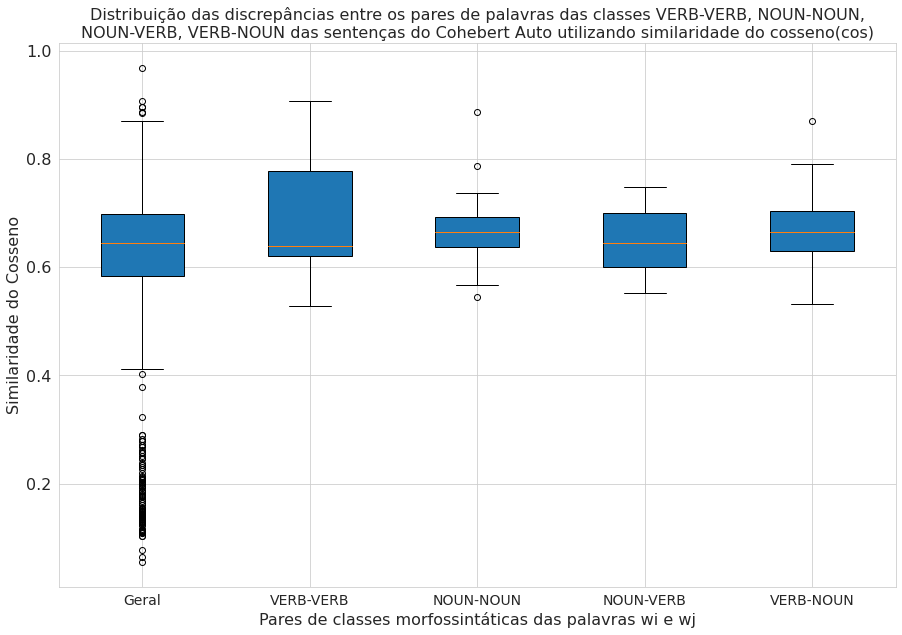

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_palavra[["cos_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_mean"]].dropna(),
           lista_comparacao_classesNV[["cos_mean"]].dropna(),
           lista_comparacao_classesVN[["cos_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["euc_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_mean"]].dropna(),
                    lista_comparacao_classesNV[["euc_mean"]].dropna(),
                    lista_comparacao_classesVN[["euc_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,euc_mean,euc_mean,euc_mean,euc_mean,euc_mean
count,2240.000000,17.000000,107.000000,34.000000,93.000000
mean,33.495596,29.762360,35.111765,33.142994,33.427674
std,5.332136,7.228043,6.217116,4.000551,5.426912
min,6.765657,15.100810,17.779648,25.501133,17.706589
25%,29.917229,25.524544,30.701530,31.170500,30.235279
50%,33.167751,32.151291,33.947063,34.185015,32.791538
75%,36.748666,35.893177,36.894691,35.371927,35.891922
max,51.497929,38.824390,51.497929,39.607944,50.615463


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


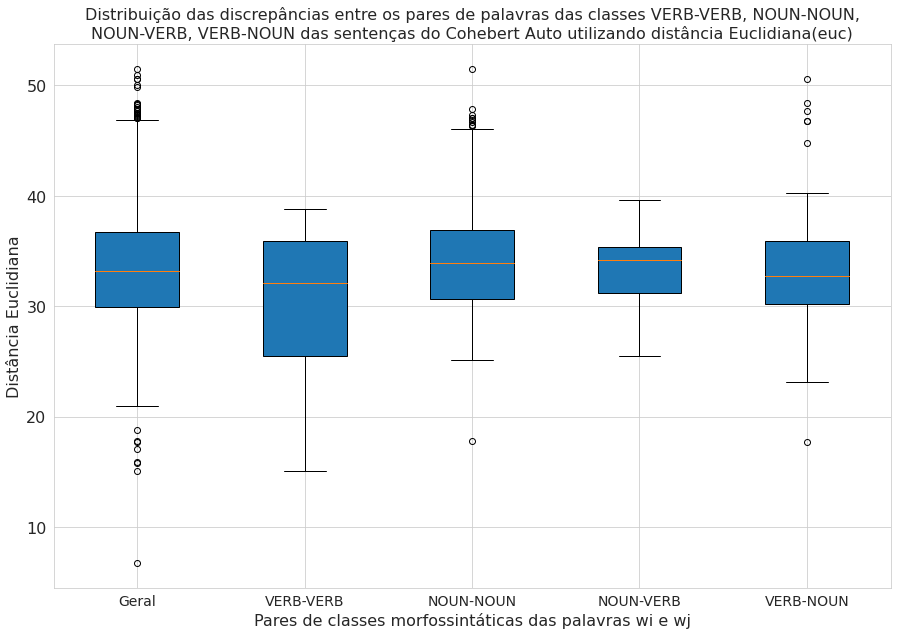

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_palavra[["euc_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_mean"]].dropna(),
           lista_comparacao_classesNV[["euc_mean"]].dropna(),
           lista_comparacao_classesVN[["euc_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["man_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_mean"]].dropna(),
                    lista_comparacao_classesNV[["man_mean"]].dropna(),
                    lista_comparacao_classesVN[["man_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,man_mean,man_mean,man_mean,man_mean,man_mean
count,2240.000000,17.000000,107.000000,34.000000,93.000000
mean,1596.039103,1422.208011,1563.541605,1573.316159,1555.047062
std,209.261450,342.101634,158.576033,178.063992,196.974841
min,166.194550,729.162960,855.080500,1253.790800,848.396240
25%,1459.655750,1240.604000,1442.609250,1447.006000,1424.465500
50%,1614.486350,1543.940000,1548.993500,1623.029650,1565.022200
75%,1737.844725,1684.711700,1692.520750,1702.098700,1712.304900
max,2187.814500,1872.722400,1881.839800,1821.293700,2009.080800


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


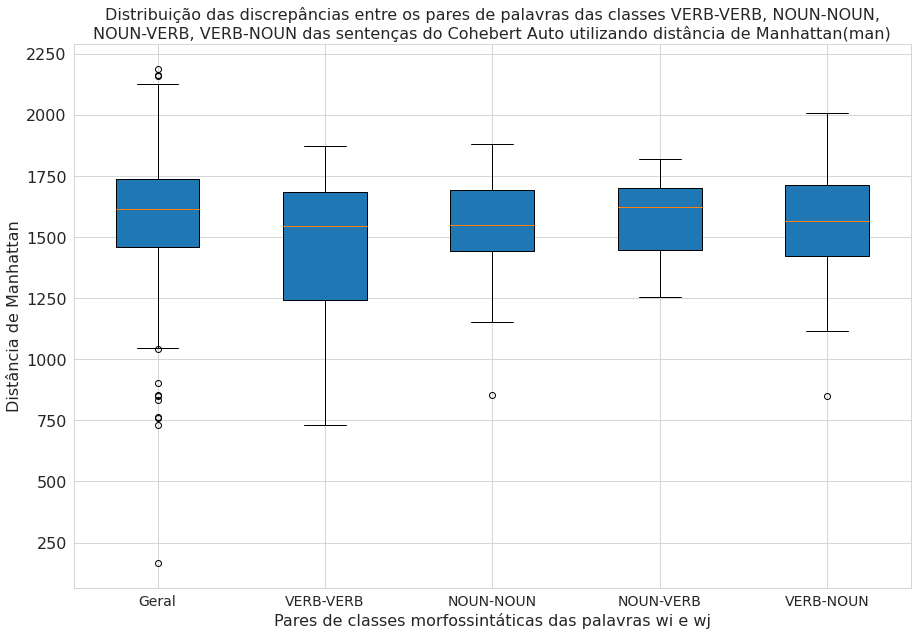

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_palavra[["man_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_mean"]].dropna(),
           lista_comparacao_classesNV[["man_mean"]].dropna(),
           lista_comparacao_classesVN[["man_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

## 3.6 Ocorrências de pares de palavras

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id"])
lista_comparacao_palavra_indexado.head()

,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
id,,,,,,,,,,,,,,
1,0,0,0,Como,SCONJ,1,enfileirar,VERB,0.759586,25.941952,1294.481300,0.673417,31.297092,1554.191700
1,0,0,0,Como,SCONJ,2,elementos,NOUN,0.607320,37.124222,1770.785400,0.607320,37.124222,1770.785400
1,0,0,0,Como,SCONJ,3,em,ADP,0.658418,33.079350,1641.086400,0.658418,33.079350,1641.086400
1,0,0,0,Como,SCONJ,4,uma,DET,0.700411,29.079645,1441.169700,0.700411,29.079645,1441.169700
1,0,0,0,Como,SCONJ,5,fila,NOUN,0.630520,31.865469,1558.006500,0.578515,35.350060,1716.585000


### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos'

# Estratégia medida
estrategia_medida = 'mean'

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]

          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1

          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9                                                    
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)
media = soma_medida / conta
print("Média medida", (medida + "_" + estrategia_medida), " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  234
Média medida cos_mean  :  0.6054385803066767


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[4] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") " + linha2[2] + "(" + linha2[3] + ")"

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de pares de palavras com similaridade acima do threshold

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):

  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold
1 pilha(NOUN) ?(PUNCT) 24
2 pilha(NOUN) uma(DET) 24
3 pilha(NOUN) em(ADP) 16
4 pilha(NOUN) elementos(NOUN) 14
5 pilha(NOUN) empilhar(VERB) 12
6 pilha(NOUN) e(CCONJ) 11
7 pilha(NOUN) Como(SCONJ) 8
8 pilha(NOUN) como(ADV) 8
9 pilha(NOUN) é(AUX) 8
10 pilha(NOUN) de(ADP) 7
11 pilha(NOUN) dados(NOUN) 7
12 pilha(NOUN) desempilhar(NOUN) 7
13 pilha(NOUN) estrutura(NOUN) 6
14 pilha(NOUN) O(PRON) 6
15 pilha(NOUN) elemento(NOUN) 5
16 pilha(NOUN) desempilhar(VERB) 4
17 pilha(NOUN) Como(ADP) 4
18 pilha(NOUN) um(DET) 4
19 pilha(NOUN) nela(PRON) 4
20 pilha(NOUN) organizar(VERB) 3


### 3.6.2 Raio de proximidade

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1

          # Calcula a distância da chaves 
          distancia = abs(linha['index_wj'] - linha['index_wi'])
            
          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1
          
          # Calcula a distância da chaves 
          distancia = abs(linha['index_wi'] - linha['index_wj'])
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  234


#### 3.6.2.2 Seleciona comparações entre palavras que esteja a um determinado raio ao redor da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
raio = 2

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do raio
        if linha2[4] <= raio:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") - " + str(linha2[4]) + " - " + linha2[2] + "(" + linha2[3] + ")"
            
            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista ordenada das 20 maiores ocorrências de pares de palavras até o raio

In [ ]:
top = 20

print("Lista ordenada das", top, "maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das 20 maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio
1 pilha(NOUN) - 1 - uma(DET) 18
2 pilha(NOUN) - 1 - ?(PUNCT) 14
3 pilha(NOUN) - 2 - em(ADP) 8
4 pilha(NOUN) - 1 - e(CCONJ) 8
5 pilha(NOUN) - 2 - como(ADV) 8
6 pilha(NOUN) - 2 - é(AUX) 8
7 pilha(NOUN) - 2 - de(ADP) 6
8 pilha(NOUN) - 1 - dados(NOUN) 6
9 pilha(NOUN) - 1 - a(DET) 2
10 pilha(NOUN) - 2 - operação(NOUN) 2
11 pilha(NOUN) - 2 - Em(ADP) 2


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:01:18 (h:mm:ss)
